In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticks
import numpy as np
import statsmodels.tsa.api as tsa
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [2]:
# testing stationarity function
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): 
    (test_stat, pval, nlags, nobs, crit_vals_d,
    icbest ) = tsa.adfuller(ts, **kwargs)
    # perform Augmented Dickey-Fuller test
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags,
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

# plotting forecast values function
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None,
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    fig, ax = plt.subplots(figsize=figsize)
    # set the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
    # plot training and testing data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # add the shaded confidence interval
    ax.fill_between(forecast_df.index,
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    return fig, ax

# displaying regression metrics function
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [3]:
# load data
df_ts = pd.read_csv("Data/ts_crimes.csv.gz", index_col="Date")

In [4]:
df_ts.head()

,BATTERY,GAMBLING,CRIMINAL DAMAGE,OFFENSE INVOLVING CHILDREN,THEFT,ASSAULT,NARCOTICS,CRIM SEXUAL ASSAULT,DECEPTIVE PRACTICE,WEAPONS VIOLATION,...,RITUALISM,DOMESTIC VIOLENCE,OBSCENITY,OTHER NARCOTIC VIOLATION,PUBLIC INDECENCY,CONCEALED CARRY LICENSE VIOLATION,NON-CRIMINAL,HUMAN TRAFFICKING,NON-CRIMINAL (SUBJECT SPECIFIED),NON - CRIMINAL
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-01 00:00:00,18,0.0,49,67.0,121,4,3.0,21.0,36.0,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-01 01:00:00,25,0.0,23,2.0,9,4,1.0,3.0,2.0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-01 02:00:00,27,0.0,24,0.0,3,5,1.0,0.0,0.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-01 03:00:00,19,0.0,15,0.0,13,0,2.0,3.0,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-01 04:00:00,23,0.0,15,0.0,3,2,0.0,2.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# change the index dtype to datetime
df_ts.index = pd.to_datetime(df_ts.index)

In [6]:
# create a time series with month frequency
df_ts_month = df_ts.resample("M").sum()

In [7]:
# check null values
df_ts_month.isna().sum().any()

False

In [8]:
# create a time series for all crimes
ts_all_crimes = df_ts_month.apply(np.sum, axis=1)

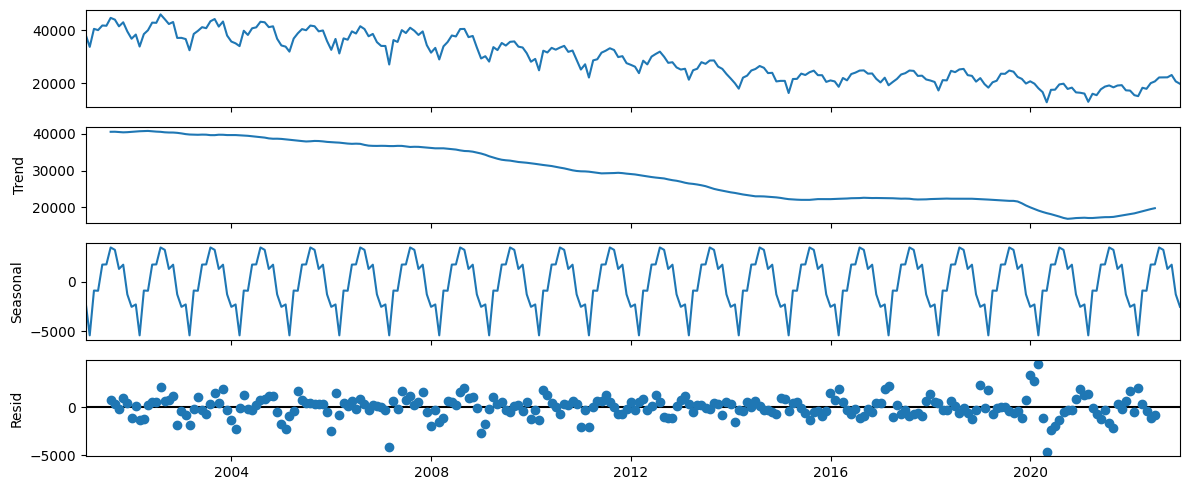

In [9]:
# decompose the Time series
decomp = tsa.seasonal_decompose(ts_all_crimes)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [10]:
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min() # seasonal component altitude
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(ts_all_crimes.max()-ts_all_crimes.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 8897.74404761905 which is ~26.89% of the variation in time series.


The seasonal component is significant so we will use a seasonal model with a period of 12 months.

In [11]:
get_adfuller_results(ts_all_crimes)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.325784,15,248,0.617295,0.05,False


The time series is not stationary so a differencing is required.

In [12]:
# determine the differencing order
d = ndiffs(ts_all_crimes)
d

1

In [13]:
# determine the seasonal differencing order
D = nsdiffs(ts_all_crimes, m=12)
D

0

we will apply one nonseasonal differencing.

In [14]:
# difference the time series
ts_all_crimes_diff = ts_all_crimes.diff().dropna()

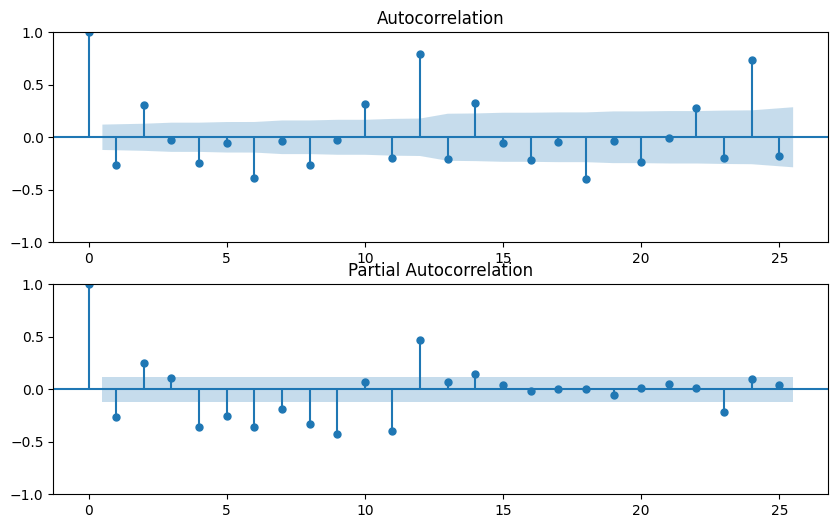

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(10,6))
tsa.graphics.plot_acf(ts_all_crimes_diff, ax=axs[0])
tsa.graphics.plot_pacf(ts_all_crimes_diff, ax=axs[1]);

There is not an obvious seasonal and non seasonal orders, thus we will try a SARIMA(1,1,1)(1,0,1)[12] model

In [16]:
# define the  number of test lags
n_test_lags = 6
# train-test split
train, test = train_test_split(ts_all_crimes, test_size=n_test_lags)

In [17]:
# orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal 

# create and fit the ARIMA model
sarima_model = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,503.968
- MSE = 2,793,786.816
- RMSE = 1,671.462
- R^2 = -1.255
- MAPE = 6.86%


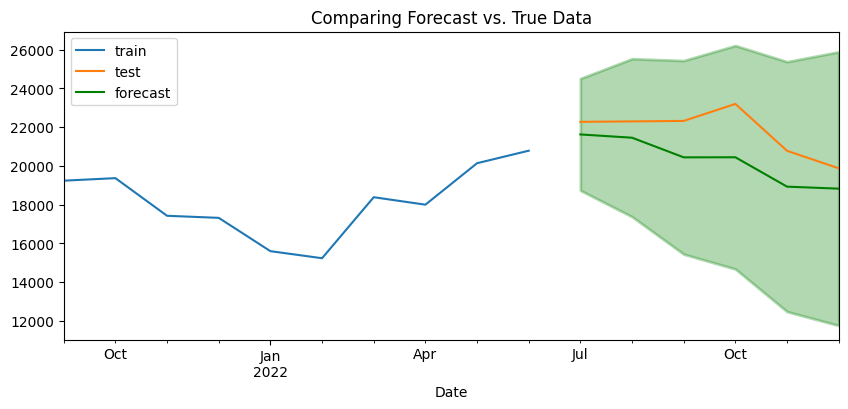

In [18]:
# obtain forecast as a dataframe with confidence intervals
forecast_df = sarima_model.get_forecast(steps=len(test)).summary_frame()
# plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df,  n_train_lags=10);
# regression metrics
regression_metrics_ts(test, forecast_df['mean'])

In [19]:
auto_model = pm.auto_arima(train, seasonal=True, m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.50 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4756.537, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4590.361, Time=1.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4647.189, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4754.725, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4738.449, Time=0.12 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4567.983, Time=3.00 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4520.454, Time=4.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=4515.408, Time=1.60 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=4642.213, Time=0.66 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=4589.400, Time=3.61 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=4615.124, Time=1.82 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.96 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=4525.443, Time=0.80 sec
 ARIMA(2,1,0)(1,0,1)[12] inte

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,525.056
- MSE = 2,839,900.826
- RMSE = 1,685.201
- R^2 = -1.293
- MAPE = 6.95%


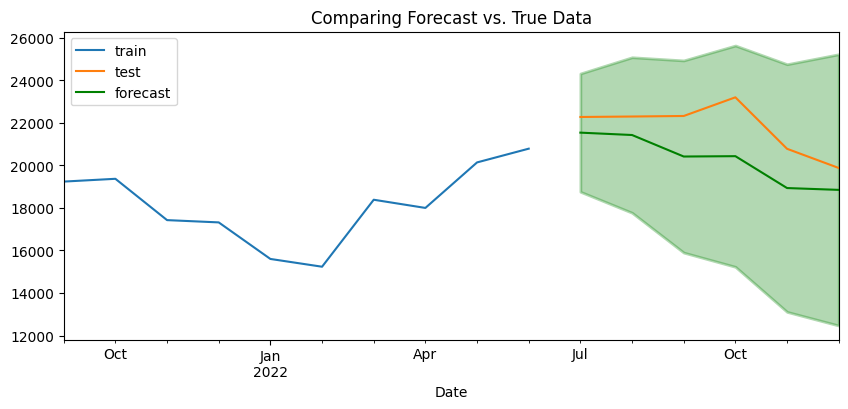

In [20]:
# define an model with the best paramters from auto_model function 
auto_model = tsa.ARIMA(train, order=auto_model.order,
                       seasonal_order=auto_model.seasonal_order).fit()
# obtain forecast as a dataframe with confidence intervals
forecast_df = auto_model.get_forecast(steps=len(test)).summary_frame()
# plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df,  n_train_lags=10);
# regression metrics
regression_metrics_ts(test, forecast_df['mean'])

Based on the The MAPE score the first model perform better so we will use it.

In [21]:
# define the final model
all_crimes_model = tsa.ARIMA(ts_all_crimes, order=(1,1,1),
                       seasonal_order=(1,0,1,12)).fit()

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


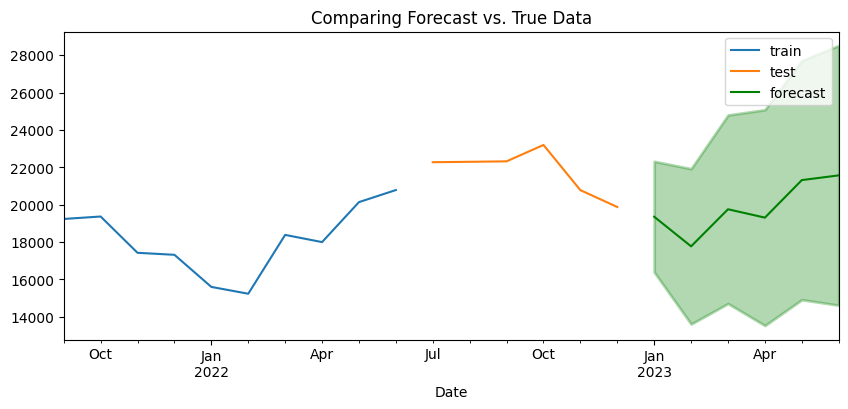

In [22]:
# obtain future forecasts beyond test data
forecast_df  = all_crimes_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecast_df, n_train_lags=10);

In [23]:
# define the starting value
starting_value = forecast_df['mean'].iloc[0]
# define the final value
final_value = forecast_df['mean'].iloc[-1]
# calculate the predicted net change
change = final_value - starting_value
# calculate the percent change
perc_change = (change / starting_value) * 100

In [24]:
print(f"- Net change in the final month in the forecast vs. the first month: {change}\n- Percent change compared to the first month in the forecast: {perc_change}")

- Net change in the final month in the forecast vs. the first month: 2213.835267401748
- Percent change compared to the first month in the forecast: 11.439045458519402


In [25]:
# create a time series for theft crimes
ts_theft_crimes = df_ts_month.THEFT

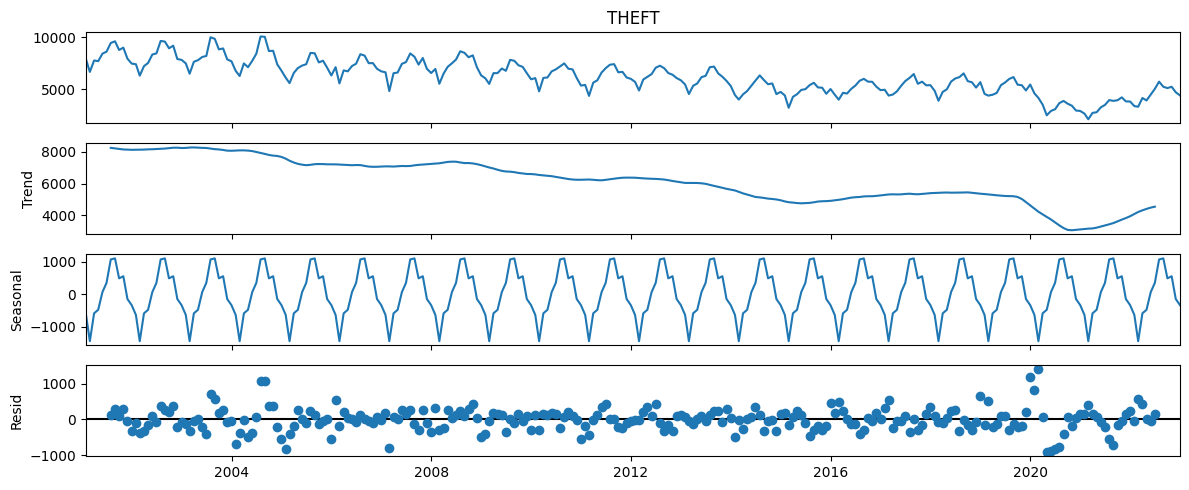

In [26]:
# decompose the Time series
decomp = tsa.seasonal_decompose(ts_theft_crimes)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [27]:
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min() # seasonal component altitude
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(ts_theft_crimes.max()-ts_theft_crimes.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 2549.988095238095 which is ~32.08% of the variation in time series.


The seasonal component is significant so we will use a seasonal model with a period of 12 months.

In [28]:
get_adfuller_results(ts_theft_crimes)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.393935,13,250,0.58518,0.05,False


The time series is not stationary so a differencing is required.

In [29]:
# determine the differencing order
d = ndiffs(ts_theft_crimes)
d

1

In [30]:
# determine the seasonal differencing order
D = nsdiffs(ts_theft_crimes, m=12)
D

0

we will apply one nonseasonal differencing.

In [31]:
# difference the time series
ts_theft_crimes_diff = ts_theft_crimes.diff().dropna()

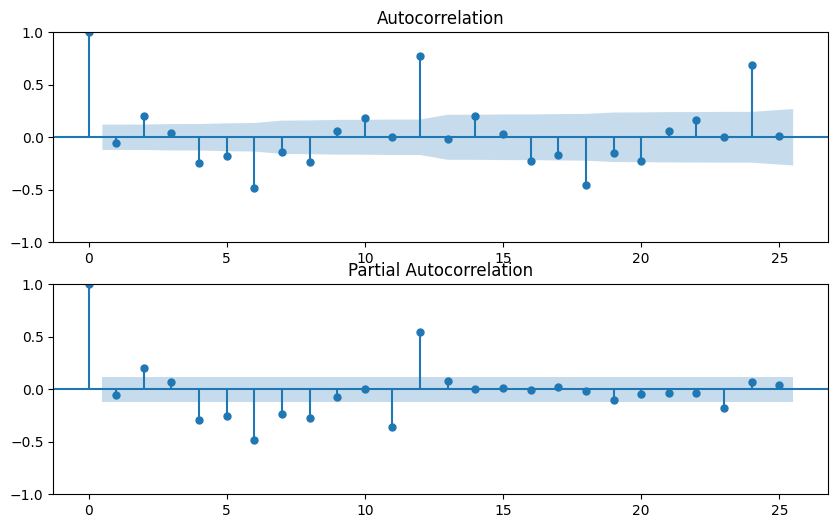

In [32]:
fig, axs = plt.subplots(2, 1, figsize=(10,6))
tsa.graphics.plot_acf(ts_theft_crimes_diff, ax=axs[0])
tsa.graphics.plot_pacf(ts_theft_crimes_diff, ax=axs[1]);

There is not an obvious seasonal and non seasonal orders, thus we will try a SARIMA(1,1,1)(1,0,1)[12] model

In [33]:
# define the  number of test lags
n_test_lags = 6
# train-test split
train, test = train_test_split(ts_theft_crimes, test_size=n_test_lags)

In [34]:
# orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal 

# create and fit the ARIMA model
sarima_model = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 237.632
- MSE = 84,226.666
- RMSE = 290.218
- R^2 = 0.523
- MAPE = 4.84%


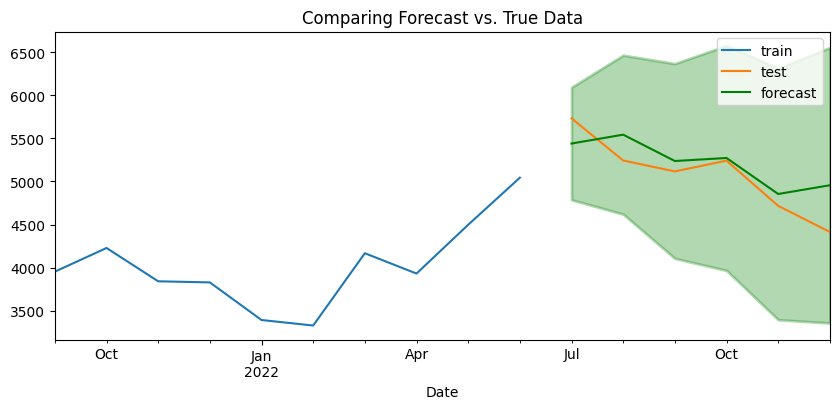

In [35]:
# obtain forecast as a dataframe with confidence intervals
forecast_df = sarima_model.get_forecast(steps=len(test)).summary_frame()
# plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df,  n_train_lags=10);
# regression metrics
regression_metrics_ts(test, forecast_df['mean'])

In [36]:
auto_model = pm.auto_arima(train, seasonal=True, m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.49 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4050.524, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3791.710, Time=0.41 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3914.631, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4048.603, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4050.805, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3774.214, Time=0.99 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3747.075, Time=2.88 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3743.960, Time=1.07 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3913.736, Time=0.38 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3742.899, Time=2.61 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3870.719, Time=0.99 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=6.11 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3754.859, Time=2.69 sec
 ARIMA(2,1,0)(1,0,2)[12] inte

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 211.162
- MSE = 72,806.823
- RMSE = 269.827
- R^2 = 0.587
- MAPE = 4.27%


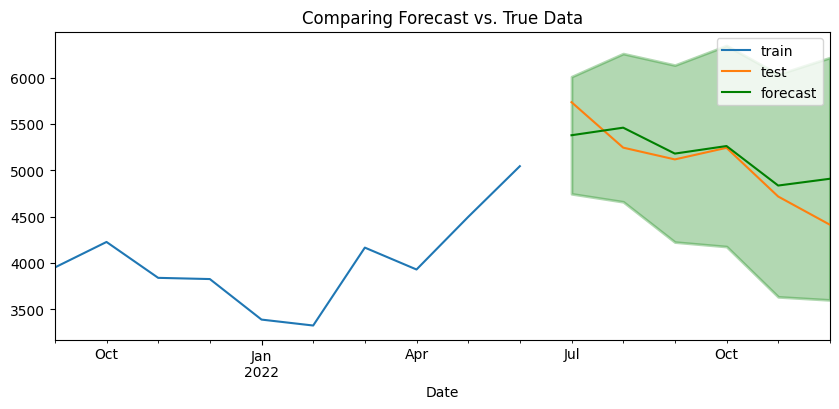

In [37]:
# define an model with the best paramters from auto_model function 
auto_model = tsa.ARIMA(train, order=auto_model.order,
                       seasonal_order=auto_model.seasonal_order).fit()
# obtain forecast as a dataframe with confidence intervals
forecast_df = auto_model.get_forecast(steps=len(test)).summary_frame()
# plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df,  n_train_lags=10);
# regression metrics
regression_metrics_ts(test, forecast_df['mean'])

Based on the The MAPE score the first model perform better so we will use it.

In [38]:
# define the final model
theft_crimes_model = tsa.ARIMA(ts_theft_crimes, order=(1,1,1),
                       seasonal_order=(1,0,1,12)).fit()

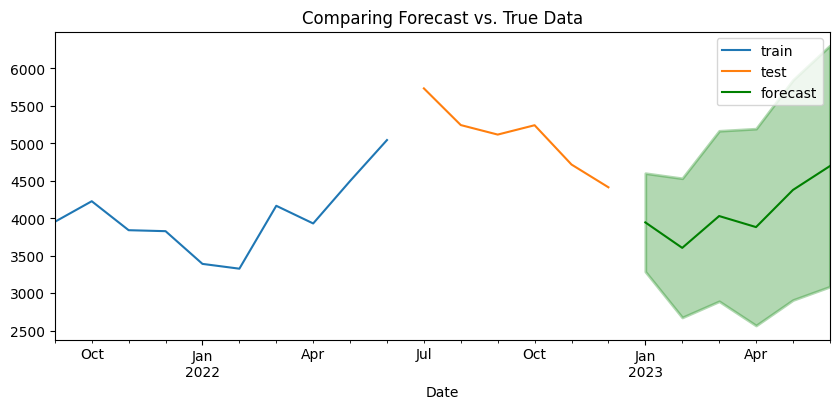

In [39]:
# obtain future forecasts beyond test data
forecast_df  = theft_crimes_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecast_df, n_train_lags=10);

In [40]:
# define the starting value
starting_value = forecast_df['mean'].iloc[0]
# define the final value
final_value = forecast_df['mean'].iloc[-1]
# calculate the predicted net change
change = final_value - starting_value
# calculate the percent change
perc_change = (change / starting_value) * 100

In [41]:
print(f"- Net change in the final month in the forecast vs. the first month: {change}\n- Percent change compared to the first month in the forecast: {perc_change}")

- Net change in the final month in the forecast vs. the first month: 752.0944780922873
- Percent change compared to the first month in the forecast: 19.068067261907192


All crimes are forecasted to have the highest net change by the end of the forecast and the theft ones are forecasted to have the highest percent change by the end of the forecast.

The trends of both all crimes and theft ones are ascendant in the next 6 months beyond the dataset so more ressources must be allocated in this period.

Text(0.5, 1.0, 'Crimes Forecasts')

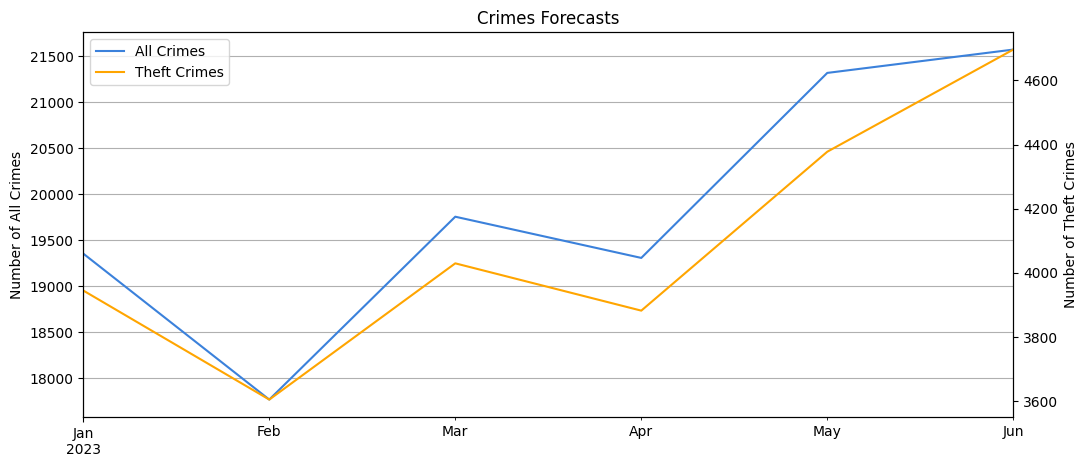

In [56]:
# get forecasts
forecast_df_all_crimes  = all_crimes_model.get_forecast(len(test)).summary_frame()
forecast_df_theft_crimes  = theft_crimes_model.get_forecast(len(test)).summary_frame()
# plot forecasts
fig, ax1 = plt.subplots(figsize=(12,5))
forecast_df_all_crimes["mean"].plot(label="All Crimes", ax=ax1, color="#3b81db")
ax1.set_ylabel("Number of All Crimes")
ax2 = ax1.twinx()
forecast_df_theft_crimes["mean"].plot(ax=ax2, label="Theft Crimes", color='orange')
ax2.set_ylabel("Number of Theft Crimes")
ax1.grid()
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc=0);
plt.title("Crimes Forecasts")